In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
pd.set_option('mode.use_inf_as_na', False)

import matplotlib.pyplot as plt
import seaborn as sns

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  

import catboost as cb

from sklearn.metrics import (
    roc_auc_score, 
    roc_curve, 
    accuracy_score, 
    classification_report, 
    mean_absolute_error, 
    mean_squared_error
)
from sklearn.model_selection import StratifiedKFold ,train_test_split
from sklearn.preprocessing import StandardScaler

import os
import pickle
import random

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    
set_seed(42)

In [3]:
class data_preprocess:
    def __init__(self, data_train, data_test):
        self.data_train = data_train
        self.data_test = data_test
        self.median_col = [
            'pressure',
            'maxtemp',
            'temparature',
            'mintemp',
            'dewpoint'
        ]
        self.fully_conc_col = [
            'humidity',
            'cloud',
            'sunshine'
        ]
        
    def _reduce_col(self):
        _cols = self.data_test.columns

        mean_wind_tr = (self.data_train['winddirection'].mean()).round()
        self.data_test['winddirection'].fillna(mean_wind_tr, inplace=True)

        for col in _cols:
            if self.data_train[col].dtype == 'int64':
                self.data_train[col] = self.data_train[col].astype('int32')
                self.data_test[col] = self.data_test[col].astype('int32')
            
            elif self.data_train[col].dtype == 'float64':
                self.data_train[col] = self.data_train[col].astype('float32')
                self.data_test[col] = self.data_test[col].astype('float32')

    def _extra_features(self):
        self.data_train['col_1'] = self.data_train['maxtemp'] - self.data_train['mintemp']
        self.data_test['col_1'] = self.data_test['maxtemp'] - self.data_test['mintemp']

        self.data_train['col_2'] = self.data_train['temparature'] - self.data_train['mintemp']
        self.data_test['col_2'] = self.data_test['temparature'] - self.data_test['mintemp']

        self.data_train['col_3'] = self.data_train['maxtemp'] - self.data_train['temparature']
        self.data_test['col_3'] = self.data_train['maxtemp'] - self.data_test['temparature']

        self.data_train['col_4'] = self.data_train['humidity'] - self.data_train['dewpoint']
        self.data_test['col_4'] = self.data_test['humidity'] - self.data_test['dewpoint']

        self.data_train['col_rad'] = np.deg2rad(self.data_train['winddirection'])
        self.data_train['col_5'] = self.data_train['windspeed'] * np.sin(self.data_train['col_rad']*3.14 / 180)
        self.data_train['col_6'] = self.data_train['windspeed'] * np.cos(self.data_train['col_rad']*3.14 / 180)
        self.data_train.drop(columns=['col_rad'], inplace=True)
        self.data_test['col_rad'] = np.deg2rad(self.data_test['winddirection'])
        self.data_test['col_5'] = self.data_test['windspeed'] * np.sin(self.data_test['col_rad']*3.14 / 180)
        self.data_test['col_6'] = self.data_test['windspeed'] * np.cos(self.data_test['col_rad']*3.14 / 180)
        self.data_test.drop(columns=['col_rad'], inplace=True)

        self.data_train['col_7'] = (
            35.74 + 
            (0.6215 * self.data_train['temparature']) - 
            (35.75 * (self.data_train['winddirection']**0.16)) + 
            (0.4275 * self.data_train['temparature'] * (self.data_train['winddirection']**0.16))
            )
        
        self.data_test['col_7'] = (
            35.74 + 
            (0.6215 * self.data_test['temparature']) - 
            (35.75 * (self.data_test['winddirection']**0.16)) + 
            (0.4275 * self.data_test['temparature'] * (self.data_test['winddirection']**0.16))
            )
    

    def _weird_features(self):
        _cols = self.data_test.columns

        data_filtered = self.data_train.copy()
        data_filtered = data_filtered.loc[data_filtered['rainfall'] == 0]

        for m_col in self.median_col:
            f_name = f'median_diff_{m_col}'
            val = data_filtered[m_col].mean()
            self.data_train[f_name] = self.data_train[m_col] - val
            self.data_test[f_name] = self.data_test[m_col] - val

        '''
        for col in self.fully_conc_col:
            self.data_train['weird_col'] = self.data_train['weird_col'] * self.data_train[col]
            self.data_test['weird_col'] = self.data_test['weird_col'] * self.data_test[col]
              
        self.data_train['weird_col'] = self.data_train['weird_col'] / 300
        self.data_test['weird_col'] = self.data_test['weird_col'] / 300
        '''
    def _process(self):
        self._reduce_col()
        self._extra_features()
        self._weird_features()

        return self.data_train, self.data_test

In [4]:
class CatBoostModel:
    def __init__(self, objective='Logloss', eval_metric='AUC', task_type = 'CPU', n_trials=100):
        self.objective = objective  
        self.eval_metric = eval_metric  
        self.n_trials = n_trials
        self.device_type = task_type
        self.best_params = None
        self.model = None
        self.history = None
        self.best_iteration = None

    def objective_function(self, trial, X_train, y_train, X_val, y_val):
        params = {
            'objective': self.objective,  
            'eval_metric': self.eval_metric,  
            'loss_function': self.objective,  
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
            'depth': trial.suggest_int('depth', 3, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 1.0, log=True),
            'random_seed': 42,
            'task_type': self.device_type,
            'verbose': False,
            'early_stopping_rounds': 50  
        }

        model = cb.CatBoostClassifier(**params) 
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  verbose=False)

        preds_proba = model.predict_proba(X_val)[:, 1]  
        score = roc_auc_score(y_val, preds_proba)
        return score

    def optimize_hyperparameters(self, X_train, y_train, X_val, y_val):
        study = optuna.create_study(direction='maximize') 
        study.optimize(lambda trial: self.objective_function(trial, X_train, y_train, X_val, y_val),
                       n_trials=self.n_trials)

        self.best_params = study.best_params
        print(f"Best parameters: {self.best_params}")

    def train(self, X_train, y_train, X_val=None, y_val=None):
        if self.best_params is None:
            raise ValueError('You must optimize hyperparameters first.')

        params = self.best_params.copy()
        params['objective'] = self.objective 
        params['eval_metric'] = self.eval_metric  
        params['loss_function'] = self.objective  
        params['random_seed'] = 42
        params['verbose'] = False

        self.model = cb.CatBoostClassifier(**params)

        if X_val is not None and y_val is not None:
            self.model.fit(X_train, y_train,
                           eval_set=[(X_val, y_val)],
                           verbose=False,
                           plot=False)
            self.history = self.model.get_evals_result()
            self.best_iteration = self.model.get_best_iteration()
        else:
            self.model.fit(X_train, y_train, verbose=False)
            self.history = None
            self.best_iteration = None

    def plot_training_history(self):
        if self.history is None:
            print('Training history is not available. Please train with validation data.')
            return

        print('Educational background structure:', self.history.keys())

        metric = self.eval_metric

        plt.figure(figsize=(10, 6))
        plt.plot(self.history['validation'][metric], label=f'Validation ({metric})')

        if self.best_iteration is not None:
            plt.axvline(self.best_iteration, color='red', linestyle='--', label=f'Best Iteration ({self.best_iteration})')
        plt.xlabel('Trails')
        plt.ylabel(metric.upper())
        plt.title(f'CatBoost Training History ({metric})')
        plt.legend()
        plt.grid(True)
        plt.show()

    def predict(self, X):
        if self.model is None:
            raise ValueError('You must train the model first.')
        return self.model.predict(X)

    def predict_proba(self, X): 
        if self.model is None:
            raise ValueError('You must train the model first.')
        return self.model.predict_proba(X)

    def save_model(self, filepath):
        with open(filepath, 'wb') as f:
            pickle.dump(self.model, f)
        print(f"Model saved to: {filepath}")

    def load_model(self, filepath):
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Model file not found: {filepath}")

        with open(filepath, 'rb') as f:
            self.model = pickle.load(f)
        print(f"Model loaded from: {filepath}")

    def evaluate(self, X_test, y_test):
        if self.model is None:
            raise ValueError("You must train the model first.")

        preds = self.predict(X_test)
        preds_proba = self.predict_proba(X_test)[:, 1] 

        accuracy = accuracy_score(y_test, preds)
        report = classification_report(y_test, preds)
        auc = roc_auc_score(y_test, preds_proba)

        print(f"Accuracy: {accuracy}")
        print("Classification Report:\n", report)
        print(f"AUC: {auc}")
        return auc

In [5]:
def stratified_kfold_cross_validation(X, y, model, n_splits=5):  
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)  
    auc_scores = []

    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        print(f"Fold {fold + 1}/{n_splits}")  

        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.optimize_hyperparameters(X_train, y_train, X_val, y_val) 
        model.train(X_train, y_train, X_val, y_val)
        model.plot_training_history()
        auc = model.evaluate(X_val, y_val) 
        auc_scores.append(auc)
        model.save_model(f"/kaggle/working/catboost_model_fold_{fold + 1}.pkl")

    print(f"AUC Mean: {np.mean(auc_scores)}")
    print(f"AUC Scores: {auc_scores}")
    
    max_index, max_value = max(enumerate(auc_scores), key=lambda x: x[1])
    return max_index

In [6]:
df_train = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')

df_train = df_train.drop(columns=['id', 'day'])
df_test_id = df_test['id']
df_test = df_test.drop(columns=['id', 'day'])

df_train_y = df_train['rainfall']

In [7]:
df_train, df_test = data_preprocess(df_train, df_test)._process()
df_train = df_train.drop(columns=['rainfall'])

In [8]:
pd.options.display.float_format = '{:.2f}'.format

In [9]:
scaler = StandardScaler()
df_train = scaler.fit_transform(df_train)
df_test = scaler.transform(df_test)
df_train_y = pd.Series(df_train_y)

Fold 1/10
Best parameters: {'iterations': 208, 'learning_rate': 0.09886481510352026, 'depth': 6, 'l2_leaf_reg': 2.186593201063415e-07}
Educational background structure: dict_keys(['learn', 'validation'])


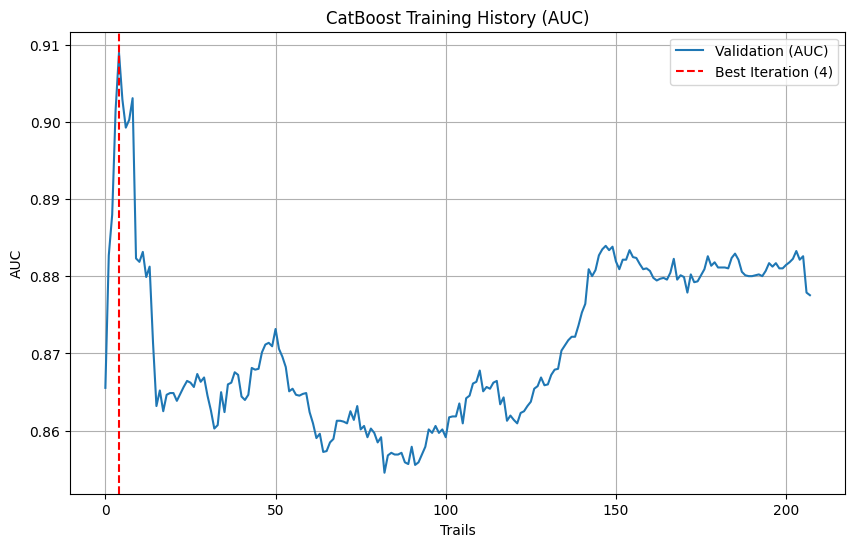

Accuracy: 0.8995433789954338
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.78      0.79        54
           1       0.93      0.94      0.93       165

    accuracy                           0.90       219
   macro avg       0.87      0.86      0.86       219
weighted avg       0.90      0.90      0.90       219

AUC: 0.9089786756453423
Model saved to: /kaggle/working/catboost_model_fold_1.pkl
Fold 2/10
Best parameters: {'iterations': 342, 'learning_rate': 0.09961013543359129, 'depth': 5, 'l2_leaf_reg': 3.855395756312415e-06}
Educational background structure: dict_keys(['learn', 'validation'])


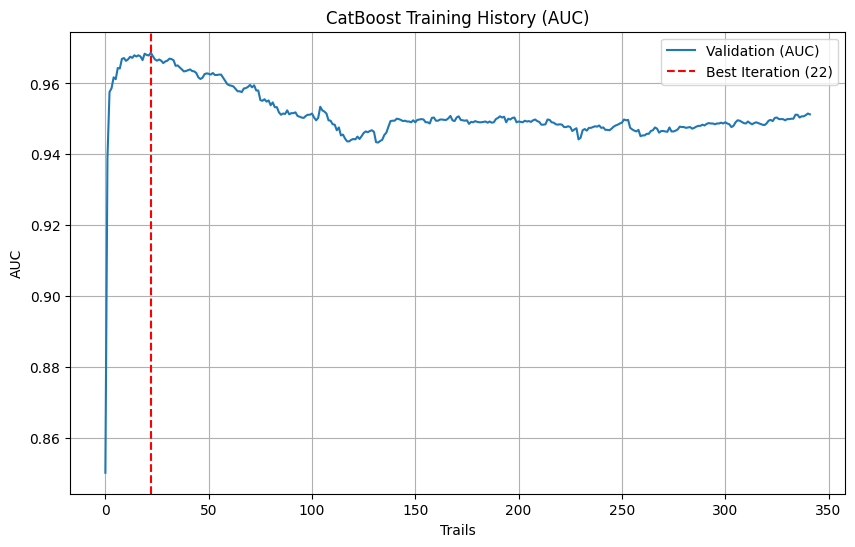

Accuracy: 0.9315068493150684
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.80      0.85        54
           1       0.94      0.98      0.96       165

    accuracy                           0.93       219
   macro avg       0.93      0.89      0.90       219
weighted avg       0.93      0.93      0.93       219

AUC: 0.9686868686868686
Model saved to: /kaggle/working/catboost_model_fold_2.pkl
Fold 3/10
Best parameters: {'iterations': 792, 'learning_rate': 0.06589194041799837, 'depth': 6, 'l2_leaf_reg': 2.528582591611368e-05}
Educational background structure: dict_keys(['learn', 'validation'])


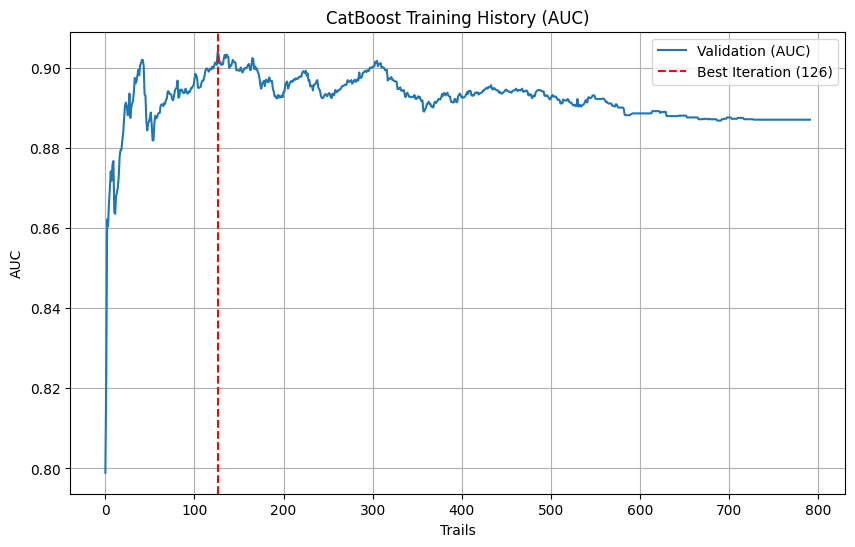

Accuracy: 0.8767123287671232
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.72      0.74        54
           1       0.91      0.93      0.92       165

    accuracy                           0.88       219
   macro avg       0.84      0.82      0.83       219
weighted avg       0.87      0.88      0.88       219

AUC: 0.9038159371492704
Model saved to: /kaggle/working/catboost_model_fold_3.pkl
Fold 4/10
Best parameters: {'iterations': 319, 'learning_rate': 0.06694847543519085, 'depth': 3, 'l2_leaf_reg': 5.619158111674118e-07}
Educational background structure: dict_keys(['learn', 'validation'])


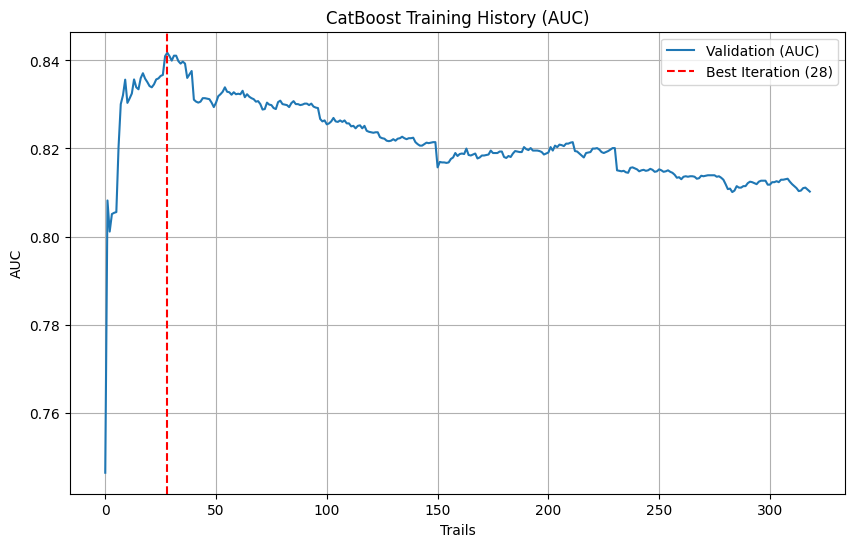

Accuracy: 0.8310502283105022
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.56      0.62        54
           1       0.86      0.92      0.89       165

    accuracy                           0.83       219
   macro avg       0.78      0.74      0.76       219
weighted avg       0.82      0.83      0.82       219

AUC: 0.8417508417508417
Model saved to: /kaggle/working/catboost_model_fold_4.pkl
Fold 5/10
Best parameters: {'iterations': 358, 'learning_rate': 0.09008164730968658, 'depth': 4, 'l2_leaf_reg': 9.74449853868168e-05}
Educational background structure: dict_keys(['learn', 'validation'])


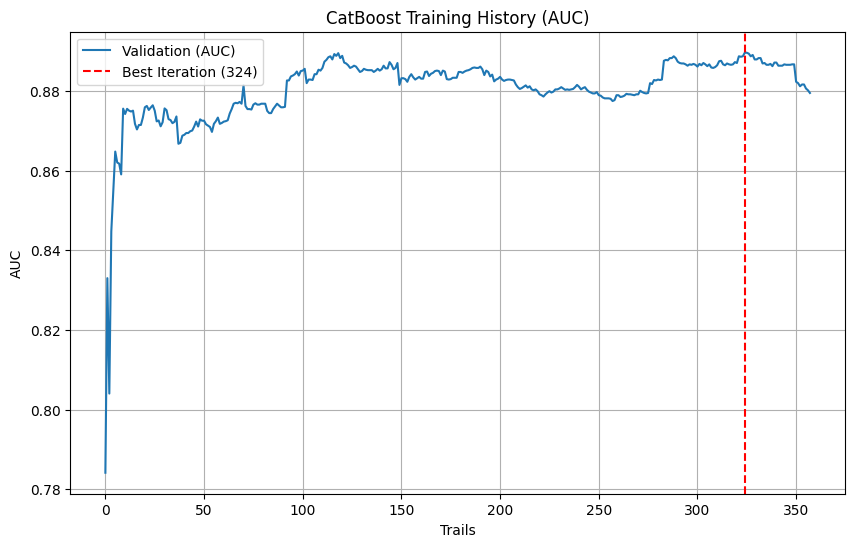

Accuracy: 0.8401826484018264
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.56      0.63        54
           1       0.87      0.93      0.90       165

    accuracy                           0.84       219
   macro avg       0.80      0.74      0.76       219
weighted avg       0.83      0.84      0.83       219

AUC: 0.8895622895622896
Model saved to: /kaggle/working/catboost_model_fold_5.pkl
Fold 6/10
Best parameters: {'iterations': 406, 'learning_rate': 0.009639858406079262, 'depth': 8, 'l2_leaf_reg': 2.3120504098854704e-08}
Educational background structure: dict_keys(['learn', 'validation'])


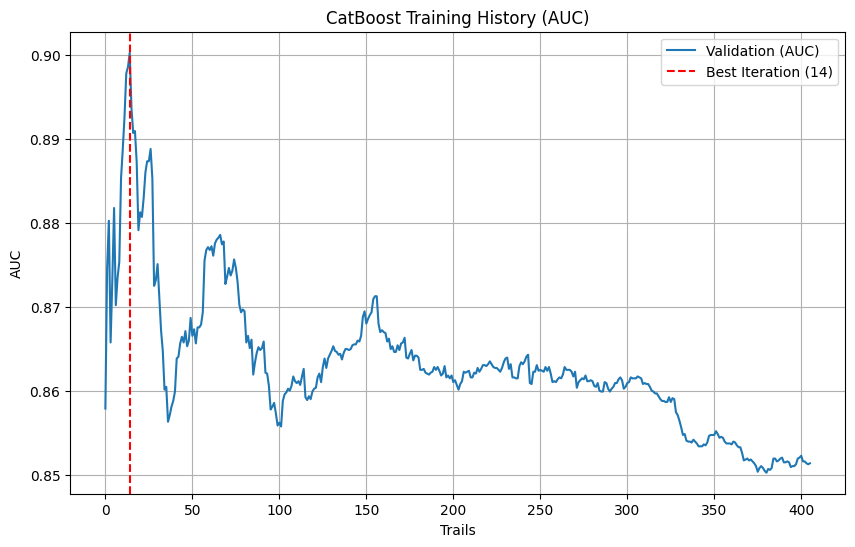

Accuracy: 0.8493150684931506
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.63      0.67        54
           1       0.88      0.92      0.90       165

    accuracy                           0.85       219
   macro avg       0.80      0.78      0.79       219
weighted avg       0.84      0.85      0.85       219

AUC: 0.9002244668911336
Model saved to: /kaggle/working/catboost_model_fold_6.pkl
Fold 7/10
Best parameters: {'iterations': 673, 'learning_rate': 0.05790516482578775, 'depth': 5, 'l2_leaf_reg': 0.0058119148175616395}
Educational background structure: dict_keys(['learn', 'validation'])


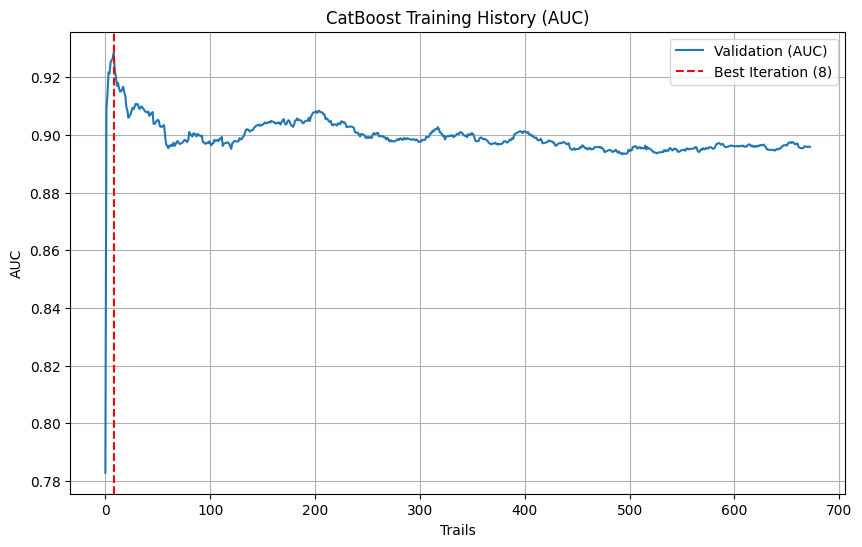

Accuracy: 0.863013698630137
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.63      0.69        54
           1       0.89      0.94      0.91       165

    accuracy                           0.86       219
   macro avg       0.83      0.78      0.80       219
weighted avg       0.86      0.86      0.86       219

AUC: 0.9285072951739619
Model saved to: /kaggle/working/catboost_model_fold_7.pkl
Fold 8/10
Best parameters: {'iterations': 173, 'learning_rate': 0.08305036654507654, 'depth': 5, 'l2_leaf_reg': 0.011876019390027083}
Educational background structure: dict_keys(['learn', 'validation'])


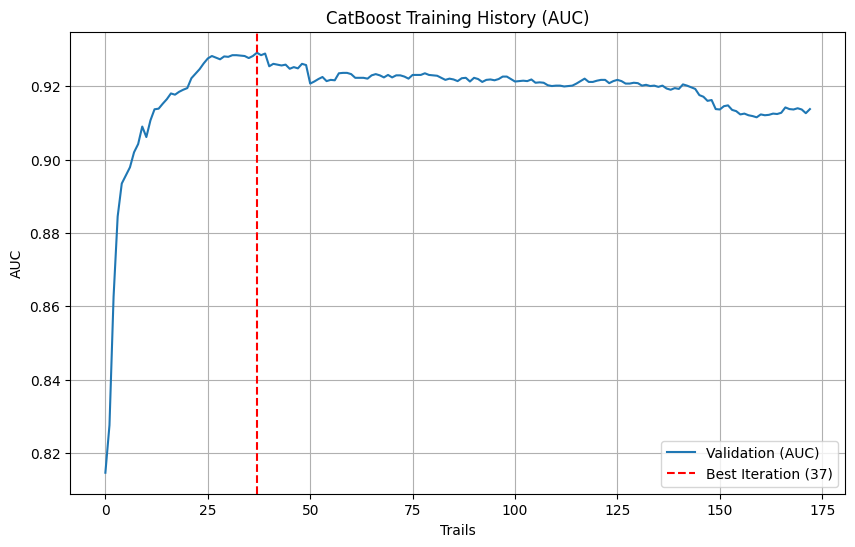

Accuracy: 0.8584474885844748
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.69      0.70        54
           1       0.90      0.92      0.91       165

    accuracy                           0.86       219
   macro avg       0.81      0.80      0.81       219
weighted avg       0.86      0.86      0.86       219

AUC: 0.9291806958473625
Model saved to: /kaggle/working/catboost_model_fold_8.pkl
Fold 9/10
Best parameters: {'iterations': 562, 'learning_rate': 0.08261234111518946, 'depth': 6, 'l2_leaf_reg': 0.0001245876170499673}
Educational background structure: dict_keys(['learn', 'validation'])


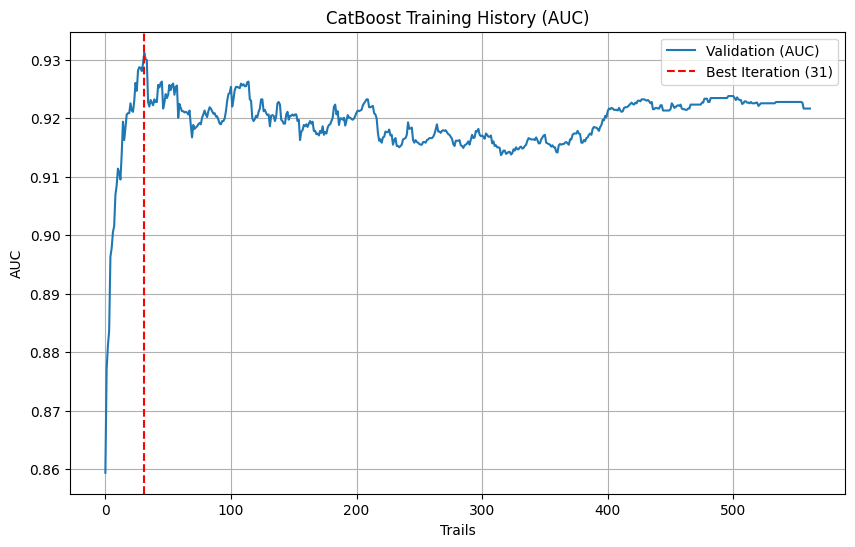

Accuracy: 0.8812785388127854
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.72      0.75        54
           1       0.91      0.93      0.92       165

    accuracy                           0.88       219
   macro avg       0.85      0.83      0.84       219
weighted avg       0.88      0.88      0.88       219

AUC: 0.9312008978675647
Model saved to: /kaggle/working/catboost_model_fold_9.pkl
Fold 10/10
Best parameters: {'iterations': 641, 'learning_rate': 0.025324580836217695, 'depth': 7, 'l2_leaf_reg': 0.10913085385291396}
Educational background structure: dict_keys(['learn', 'validation'])


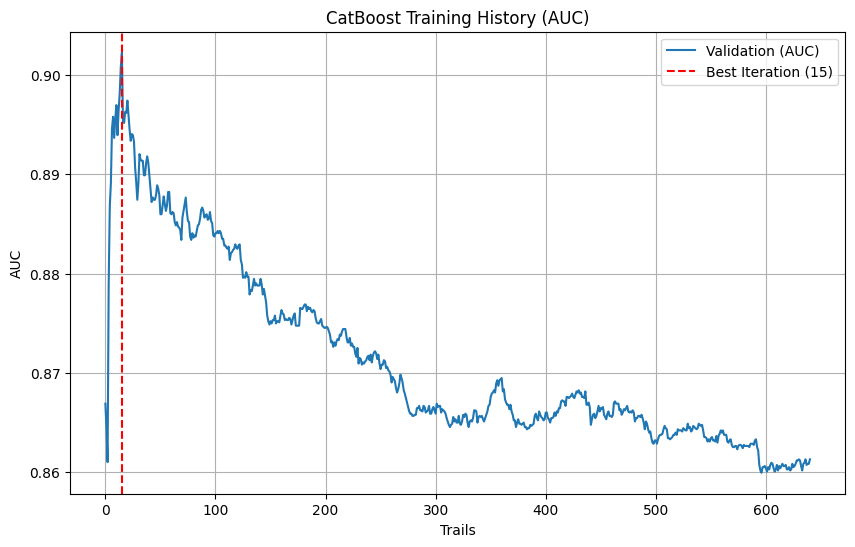

Accuracy: 0.863013698630137
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.67      0.71        54
           1       0.89      0.93      0.91       165

    accuracy                           0.86       219
   macro avg       0.82      0.80      0.81       219
weighted avg       0.86      0.86      0.86       219

AUC: 0.9022446689113356
Model saved to: /kaggle/working/catboost_model_fold_10.pkl
AUC Mean: 0.9104152637485969
AUC Scores: [0.9089786756453423, 0.9686868686868686, 0.9038159371492704, 0.8417508417508417, 0.8895622895622896, 0.9002244668911336, 0.9285072951739619, 0.9291806958473625, 0.9312008978675647, 0.9022446689113356]
CPU times: user 28min 12s, sys: 3min 32s, total: 31min 45s
Wall time: 9min 39s


In [10]:
%%time
catboost_model = CatBoostModel(objective='Logloss', eval_metric='AUC', task_type='CPU', n_trials=100)
best_auc_score = stratified_kfold_cross_validation(df_train, df_train_y, catboost_model, n_splits=10)

In [11]:
loaded_model = CatBoostModel()
model_name = f'/kaggle/working/catboost_model_fold_{best_auc_score + 1}.pkl'
loaded_model.load_model(model_name)
predictions = loaded_model.predict(df_test)
new_probabilities = loaded_model.predict_proba(df_test)[:, 1]
print("Predictions:",predictions)
print("Probabilities:\n", new_probabilities)

Model loaded from: /kaggle/working/catboost_model_fold_2.pkl
Predictions: [1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1
 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1
 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1

In [12]:
output = pd.DataFrame({
    'id': df_test_id, 
    'rainfall': new_probabilities
})

output

,id,rainfall
0,2190,0.94
1,2191,0.94
2,2192,0.85
3,2193,0.26
4,2194,0.17
...,...,...
725,2915,0.92
726,2916,0.93
727,2917,0.92
728,2918,0.94


In [13]:
output.to_csv('submission.csv', index=False)